# 01-02 Geoprocessing

This notebook contains information on some basic geoprocessing tasks. Again, it is very much inspired and based on 
[Abdishakur's blogposts](https://towardsdatascience.com/@shakasom). 

## 1. GeoDataFrames and GeoSeries

first let's import the necessary packages:

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib
import matplotlib.pyplot as plt 
import folium
import plotly_express as px

In [3]:
# Let's read the data:
countries = gpd.read_file('../Data/countries.gpkg')
cities = gpd.read_file('../Data/cities.geojson')

__DataFrame__: a pandas dataframe is a common tabular data structure.

__GeoDataFrame__: is similar to a normal pandas dataframe, except that it also contains a column called 'geometry', which contains geospatial attributes/information in the form of Points, Polygons or Multi-Polygons. This geometry column is also refered to as a _geoseries_.

__GeoSeries__: is a set of geospatial information, so it basically contains _only_ the geometry column. 

## 2. Table Join and Spatial Join

Table join is an operation where two seperate tables are sharing one, or multiple columns. The two tables can then be joined through a __table join__ which combines the tables based on their shared column. __spatial join__ refers to joining different tables based on geographic information such as joining per city or country.

### 2.1. Table Join

In [5]:
# To simplify let us seperate country table into two tables. 

# This table holds the geometry and country names
country_shapes = countries[['geometry', 'NAME']]
print(country_shapes.head())

# This table holds Country names and Population estimate
country_names = countries[['NAME', 'POP_EST']]
print(country_names.head())
# Notice that is not geodataframe as it does not have any geometry.
# Check its type

                                            geometry       NAME
0  MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...  Indonesia
1  MULTIPOLYGON (((117.70361 4.16341, 117.69711 4...   Malaysia
2  MULTIPOLYGON (((-69.51009 -17.50659, -69.50611...      Chile
3  MULTIPOLYGON (((-69.51009 -17.50659, -69.51009...    Bolivia
4  MULTIPOLYGON (((-69.51009 -17.50659, -69.63832...       Peru
        NAME    POP_EST
0  Indonesia  260580739
1   Malaysia   31381992
2      Chile   17789267
3    Bolivia   11138234
4       Peru   31036656


In [6]:
# We can join these on their shared column NAME, this is a Table join
# Merge country_shapes to country names on ISO_A3 Column. 
country_merged = country_shapes.merge(country_names, on='NAME', how='left')
country_merged.head()

,geometry,NAME,POP_EST
0,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...",Indonesia,260580739
1,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4...",Malaysia,31381992
2,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611...",Chile,17789267
3,"MULTIPOLYGON (((-69.51009 -17.50659, -69.51009...",Bolivia,11138234
4,"MULTIPOLYGON (((-69.51009 -17.50659, -69.63832...",Peru,31036656


### 2.2. Spatial Join

Now let's say we want to join based on location. For example, we might want to know which country contains which city. To perform a spatial join, you can use ``sjoin()``.

Here, we use inner merging, which means only rows that are present in both datasets are maintained. Furthermore, there are different options (see the ``op='within'``). Some possible options are:

* __within__: takes city points that are within a polygon
* __intersect__: which takes polygons that intersect (I guess?)
* __contain__: which countries contain the city points

In [8]:
# This gdf holds the geometry and country names
country_names = countries[['geometry', 'NAME']]

# This gdf holds the geometry and city names
cities_names = cities[['name', 'geometry']]

# Merge city names and country names
cities_with_country = gpd.sjoin(cities_names, country_names, how="inner", op='within')
cities_with_country.sample(5)

,name,geometry,index_right,NAME
3787,Fukui,POINT (136.22005 36.07042),185,Japan
6674,Shymkent,POINT (69.59502 42.32001),42,Kazakhstan
2386,Badajoz,POINT (-6.96997 38.88043),67,Spain
1778,Zenica,POINT (17.91998 44.21997),131,Bosnia and Herz.
3936,Orléans,POINT (1.90003 47.90042),22,France


## 3. Buffer Analysis

In buffer analyses, you take a point and draw a buffer around it with a certain distance. Note that it is very important here to pay attention to your crs. If your data is not projected into a crs where meters are used, your distances become messy and will not reflect meters either.

Let's find one specific city ('Stockholm') and draw a buffer around it. Because this city is in Sweden, we can use a swedish crs system (epsg:3006).

In [11]:
# Find out stockholm from the cities
stockholm = cities[cities.name == 'Stockholm']
stockholm = stocholm.to_crs({'init': 'epsg:3006'})
stockholm

,name,worldcity,megacity,latitude,longitude,pop_max,pop_min,pop_other,geometry
7287,Stockholm,1.0,1,59.35076,18.097335,1264000,1253309,0,POINT (675974.010 6583418.116)


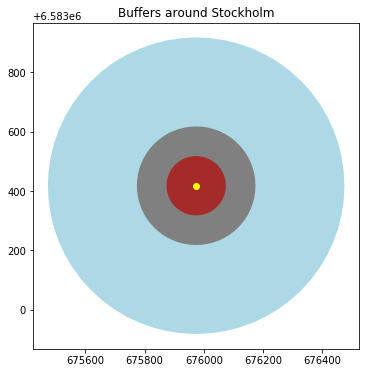

In [14]:
# Let us create a buffer of 500, 200, 100 meters and plot them
stockholm_100 = stockholm.buffer(100)
stockholm_200 = stockholm.buffer(200)
stockholm_500 = stockholm.buffer(500)

fig, ax = plt.subplots(figsize=(8,6))

stockholm_500.plot(ax=ax, color='lightblue')
ax.set_title('Buffers around Stockholm')
stockholm_200.plot(ax=ax, color='gray')
stockholm_100.plot(ax=ax, color='brown')
stockholm.plot(ax=ax, color='Yellow');

# 4. Overlay Analysis

To gain more insight into your geographical data, it is useful to know something about __set operations__. There are a number of different set operations which can be interesting. 

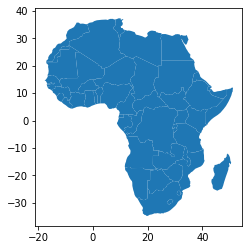

In [16]:
# Let us see what data is available in Geopandas (these are the same as the countries and cities, but in gpd already)
gpd.datasets.available

# Read from the geopandas dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
capitals = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

# Select Africa
africa = world[world['continent'] == "Africa"]
africa = africa[['geometry', 'name']]

#africa.shape
africa.plot()

In [17]:
# Project to crs that uses meters as distance measure
africa = africa.to_crs('+init=epsg:3395')
capitals = capitals.to_crs('+init=epsg:3395')

Now let's say that you only want to consider or identify the 'core' of the country (the portion of the country within a 500km radius of the capital city. 

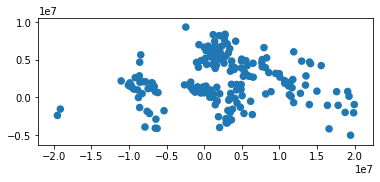

In [18]:
# make 500km buffer around the capitals
capitals['geometry']= capitals.buffer(500000)
capitals.plot()

Text(0.5, 1, 'This shows the peripheries of the countries')

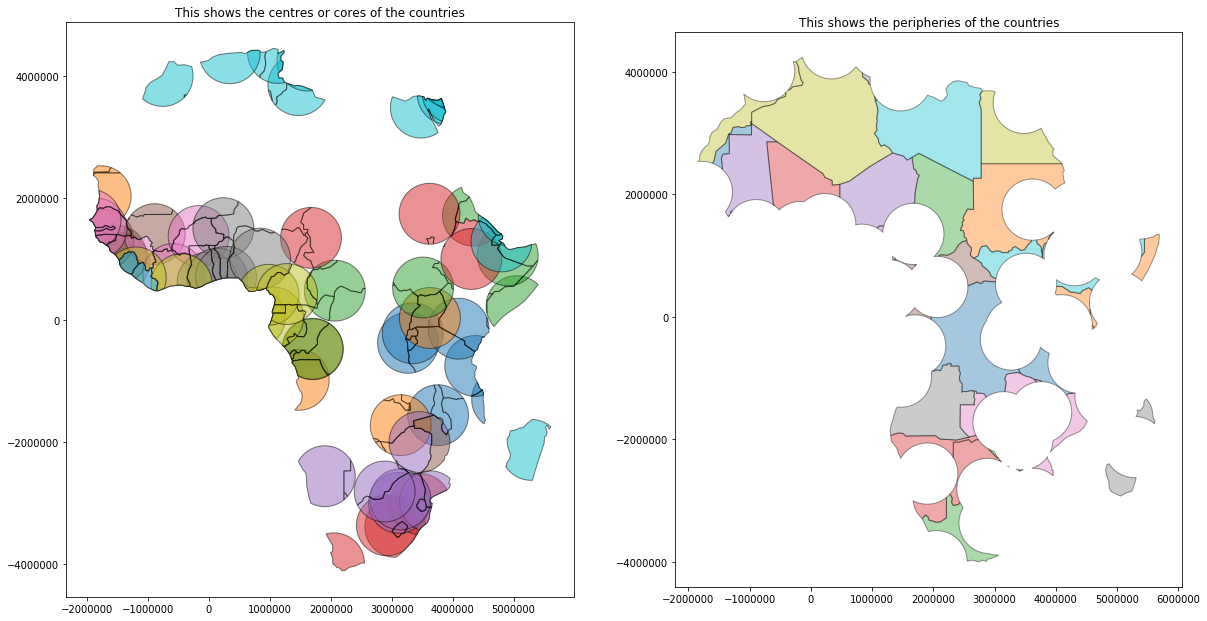

In [20]:
africa_cores = gpd.overlay(africa, capitals, how='intersection')
africa_peripheries = gpd.overlay(africa, capitals, how='difference')
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 16))
africa_cores.plot(alpha=0.5, edgecolor='k', cmap='tab10', ax=ax1)
ax1.set_title('This shows the centres or cores of the countries')
africa_peripheries.plot(alpha=0.4, edgecolor='k', cmap='tab10', ax=ax2)
ax2.set_title('This shows the peripheries of the countries')

Text(0.5, 1, 'This shows the peripheries of the countries')

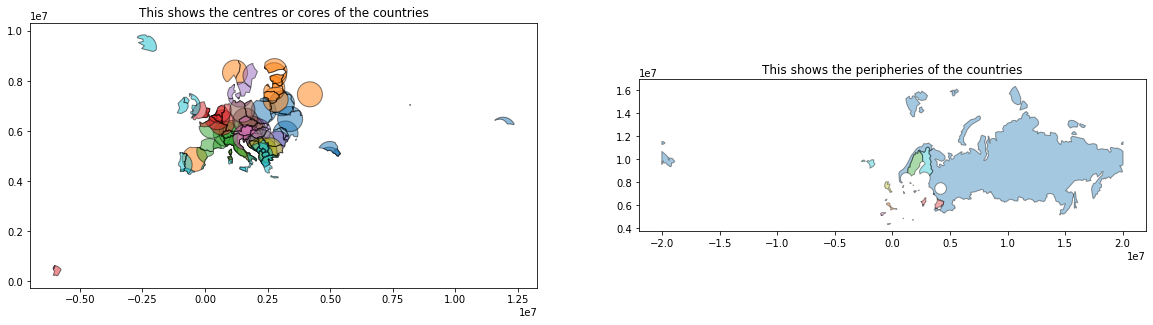

In [21]:
# Doing the same for Europe

# Select Africa
europe = world[world['continent'] == "Europe"]
europe = europe[['geometry', 'name']]
europe = europe.to_crs('+init=epsg:3395')

# Make the plot
europe_cores = gpd.overlay(europe, capitals, how='intersection')
europe_peripheries = gpd.overlay(europe, capitals, how='difference')

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 16))
europe_cores.plot(alpha=0.5, edgecolor='k', cmap='tab10', ax=ax1)
ax1.set_title('This shows the centres or cores of the countries')
europe_peripheries.plot(alpha=0.4, edgecolor='k', cmap='tab10', ax=ax2)
ax2.set_title('This shows the peripheries of the countries')